In [1]:
import csv
import itertools

from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

import stargaze

In [2]:
with open("./sdss-all-stars.csv", newline="") as f:
    stars = list(csv.DictReader(f))

In [3]:
models = []
redshift = []
names = []
magnitudes = []

for star in stars[:30]:
    url = (
        "https://data.sdss.org/sas/dr18/spectro/sdss/redux"
        f"/{star["version"]}/spectra/lite/{star["plate"]:>04}"
        f"/spec-{star["plate"]:>04}-{star["mjd"]:>05}-{star["fiber"]:>04}.fits"
    )

    with fits.open(url) as hdul:
        first_wavelength = hdul["PRIMARY"].header["COEFF0"]
        dispersion_per_pixel = hdul["PRIMARY"].header["COEFF1"]

        models.append(hdul["COADD"].data["model"])

        spec_obj = hdul["SPECOBJ"] if "SPECOBJ" in hdul else hdul["SPALL"]
        redshift.append(spec_obj.data["Z"][0])
        names.append(spec_obj.data["ELODIE_OBJECT"][0])
        magnitudes.append(spec_obj.data["SPECTROFLUX"][0])

num_samples = min(model.shape[0] for model in models)
models = np.vstack(list(model[:num_samples] for model in models))
redshift = np.array(redshift)
magnitudes = np.array(magnitudes)

In [4]:
temperatures = stargaze.temperatures(models, redshift, first_wavelength, dispersion_per_pixel)

 INFO [stargaze::temperatures:121] entering function
 INFO [stargaze::temperatures:138] spectra_per_run=30 samples_per_spectra=3811
 INFO [stargaze::temperatures:169] calling `reduce_by_key`
 INFO [stargaze::temperatures:191] calling `transform`
 INFO [stargaze::temperatures:209] calling `transform`
 INFO [stargaze::temperatures:223] finished in 118ms


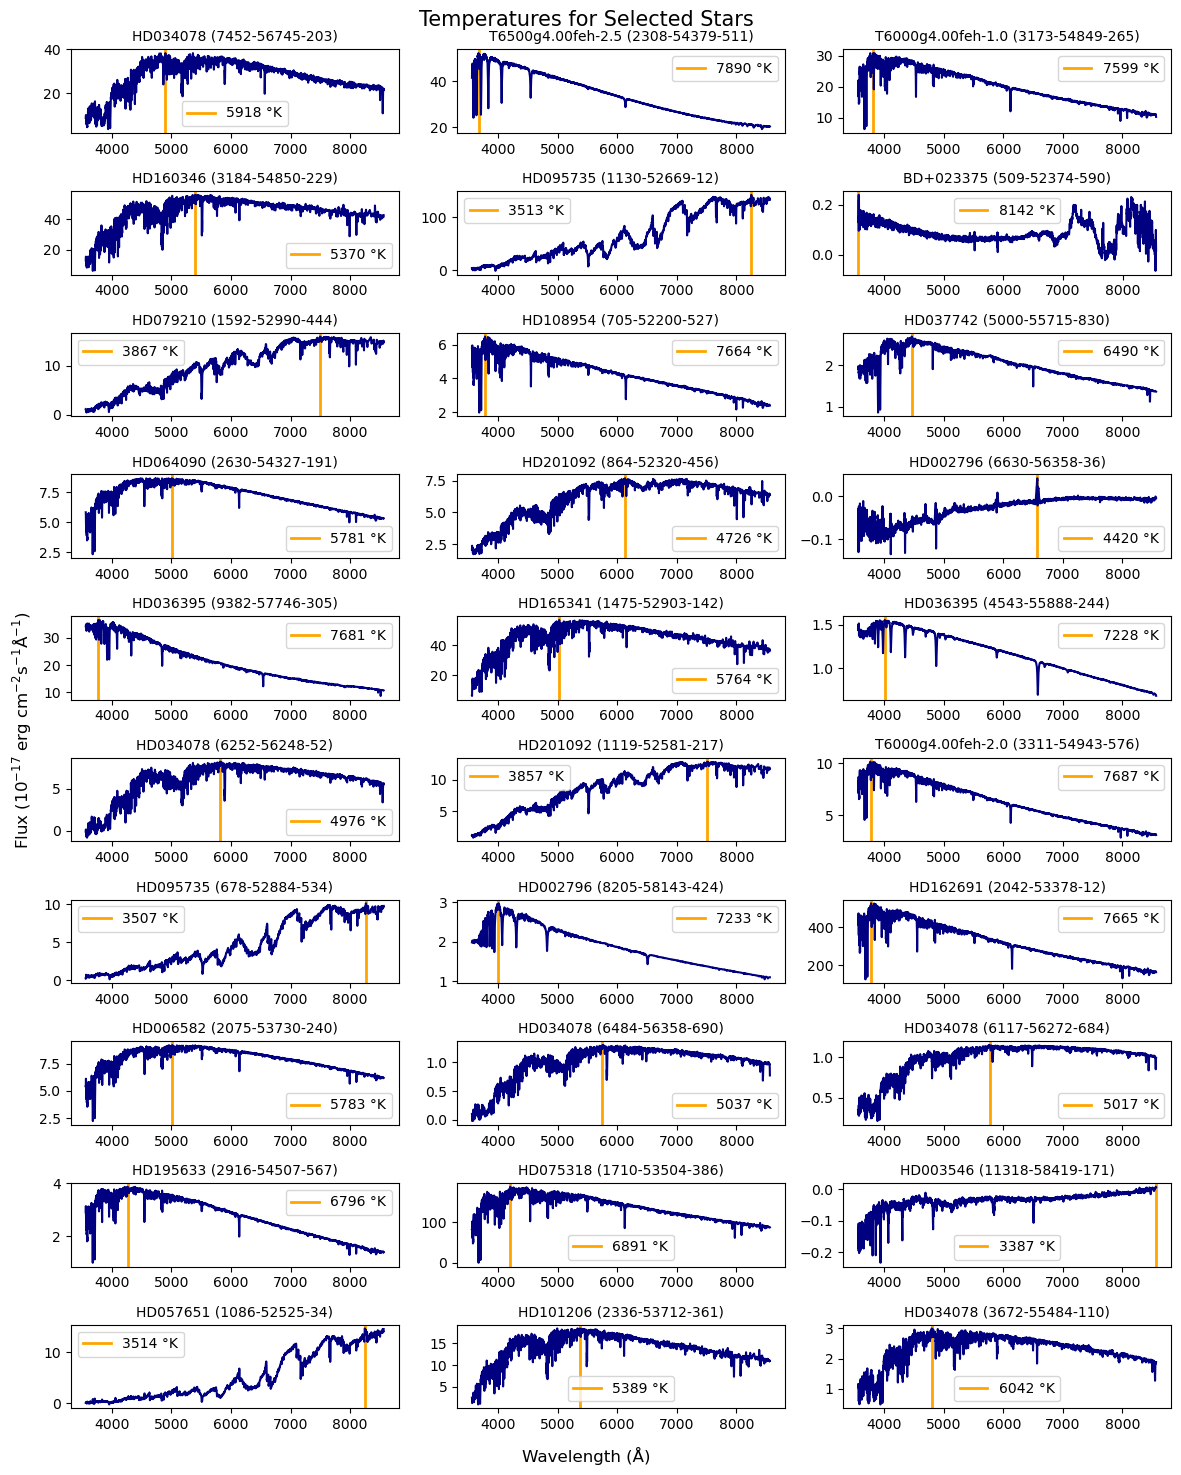

In [5]:
fig, axs = plt.subplots(10, 3, figsize=(12, 15))

x = np.logspace(start=first_wavelength, stop=first_wavelength + num_samples * dispersion_per_pixel, num=num_samples)
wien_b = 28980000

for i, j in itertools.product(range(3), range(10)):
    ax = axs[j, i]
    idx = i + j * 3
    temp = temperatures[idx]["temperature"]

    ax.set_title(f"{names[idx]} ({stars[idx]["plate"]}-{stars[idx]["mjd"]}-{stars[idx]["fiber"]})", size=10)
    ax.axvline(x=wien_b / temp, color="orange", linewidth=2, label=f"{temp} °K")
    ax.plot(x, models[idx], c="navy")
    ax.legend()

fig.suptitle("Temperatures for Selected Stars", size=15)
fig.supxlabel(r"Wavelength (Å)")
fig.supylabel(r"Flux ($10^{-17}\ \text{erg}\ \text{cm}^{-2} \text{s}^{-1} \text{Å}^{-1}$)")
plt.tight_layout()